#Objective

Answer “what if?” business questions:

Festival surge

Digital adoption increase

ATM expansion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import joblib

df = pd.read_csv("/content/drive/MyDrive/ATM_Forecasting_system/district_month_MODEL_READY_LAGS.csv")
model = joblib.load("/content/drive/MyDrive/ATM_Forecasting_system/models/xgboost.pkl")

TARGET = "district_atm_withdrawal_volume_mn"
FEATURES = [c for c in df.columns if c != TARGET]

In [ ]:
df["baseline_pred"] = model.predict(df[FEATURES])


Scenario 1 — Festival Surge (+20% short-term demand)

In [ ]:
festival_df = df.copy()

festival_df["roll_mean_3"] *= 1.20
festival_df["lag_1"] *= 1.15

festival_df["festival_pred"] = model.predict(festival_df[FEATURES])

In [ ]:
festival_df["delta"] = (
    festival_df["festival_pred"] - festival_df["baseline_pred"]
)

Scenario 2 — Digital Surge (UPI +30%)

In [ ]:
digital_df = df.copy()

digital_df["digital_share_txn"] += 0.30
digital_df["atm_share_txn"] -= 0.30

digital_df["digital_pred"] = model.predict(digital_df[FEATURES])

Scenario 3 — ATM Expansion (+15%)

In [ ]:
atm_expand_df = df.copy()
atm_expand_df["num_atms"] *= 1.15

atm_expand_df["atm_expand_pred"] = model.predict(atm_expand_df[FEATURES])


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

plt.style.use("seaborn-v0_8")


In [ ]:
rf  = joblib.load("/content/drive/MyDrive/ATM_Forecasting_system/models/random_forest.pkl")
gb  = joblib.load("/content/drive/MyDrive/ATM_Forecasting_system/models/gradient_boosting.pkl")
xgb = joblib.load("/content/drive/MyDrive/ATM_Forecasting_system/models/xgboost.pkl")


In [ ]:
test_df = df[df["year"] >= 2024].reset_index(drop=True)


In [ ]:
TARGET = "district_atm_withdrawal_volume_mn"

FEATURES = [
    c for c in test_df.columns
    if c not in [TARGET, "state_name", "district_name", "date"]
]

X_test = test_df[FEATURES]


In [ ]:
df_model_training = pd.read_csv(
    "/content/drive/MyDrive/ATM_Forecasting_system/district_month_MODEL_READY_LAGS.csv"
)

TARGET = "district_atm_withdrawal_volume_mn"
FEATURES_FOR_MODELS = [c for c in df_model_training.columns if c != TARGET]

test_df_for_models = df_model_training[df_model_training["year"] >= 2024].copy()
X_test_corrected = test_df_for_models[FEATURES_FOR_MODELS]

rf_pred  = rf.predict(X_test_corrected)
gb_pred  = gb.predict(X_test_corrected)
xgb_pred = xgb.predict(X_test_corrected)

baseline_pred = (
    0.4 * rf_pred +
    0.3 * gb_pred +
    0.3 * xgb_pred
)


In [ ]:
X_festival = X_test_corrected.copy()

X_festival["atm_share_txn"] *= 1.10
X_festival["digital_share_txn"] *= 0.95

festival_pred = (
    0.4 * rf.predict(X_festival) +
    0.3 * gb.predict(X_festival) +
    0.3 * xgb.predict(X_festival)
)


In [ ]:
X_digital = X_test_corrected.copy()

X_digital["upi_txn_volume_mn"] *= 1.20
X_digital["digital_share_txn"] *= 1.15
X_digital["atm_share_txn"] *= 0.85

digital_pred = (
    0.4 * rf.predict(X_digital) +
    0.3 * gb.predict(X_digital) +
    0.3 * xgb.predict(X_digital)
)


In [ ]:
viz_df = test_df_for_models.copy().reset_index(drop=True)


meta_test = meta[meta["year"] >= 2024].copy().reset_index(drop=True)

viz_df['district_name'] = meta_test['district_name']
viz_df['date'] = meta_test['date']

viz_df["Baseline"] = baseline_pred
viz_df["Festival"] = festival_pred
viz_df["Digital"]  = digital_pred

In [ ]:
district_name = "pune"

district_df = viz_df[
    viz_df["district_name"] == district_name
].sort_values("date")


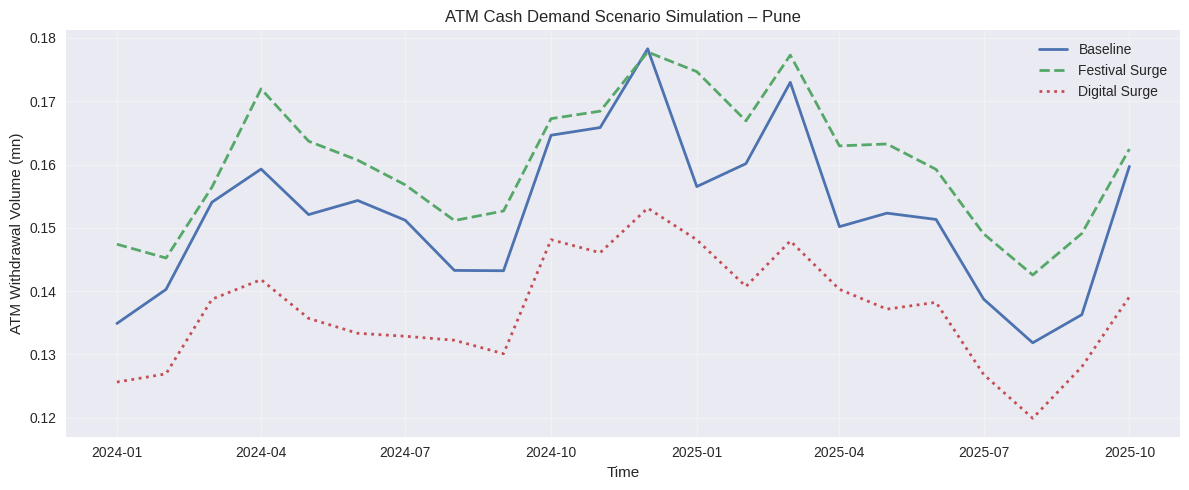

In [ ]:
plt.figure(figsize=(12,5))

plt.plot(
    district_df["date"],
    district_df["Baseline"],
    label="Baseline",
    linewidth=2
)

plt.plot(
    district_df["date"],
    district_df["Festival"],
    label="Festival Surge",
    linestyle="--",
    linewidth=2
)

plt.plot(
    district_df["date"],
    district_df["Digital"],
    label="Digital Surge",
    linestyle=":",
    linewidth=2
)

plt.title(f"ATM Cash Demand Scenario Simulation – {district_name.title()}")
plt.xlabel("Time")
plt.ylabel("ATM Withdrawal Volume (mn)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
summary = pd.DataFrame({
    "Scenario": ["Baseline", "Festival", "Digital"],
    "Avg Monthly Demand (mn)": [
        baseline_pred.mean(),
        festival_pred.mean(),
        digital_pred.mean()
    ]
})

summary


,Scenario,Avg Monthly Demand (mn)
0,Baseline,0.142972
1,Festival,0.150801
2,Digital,0.126360
